In [1]:
#!pip install matplotlib
import numpy as np
import pandas as pd
#from sklearn.cluster import DBSCAN
#from pykalman import KalmanFilter
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from scipy.spatial.distance import cdist
import time
import csv
from collections import namedtuple

import sys
sys.path.append('build')  # Add the 'build' directory to the Python path

import dbscan_module  # Import the shared object file

In [3]:
def plot_kalman_update_point(cluster_points, cluster_center):
    # Assuming cluster_points is a 2D numpy array with x and y coordinates
    #print(cluster_points[-5:])
    num_points = cluster_points.shape[0]
    # Generate a range of colors that go from light to dark
    colors = np.linspace(0.3, 1, num_points)  # Adjust 0.3 to 1 for darker shades
    
    # Plot the cluster points with varying darkness
    scatter = plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors, cmap='Greys')
    
    # Plot the cluster center
    plt.scatter(cluster_center[0], cluster_center[1], color='red', marker='x', label='Cluster Center')
    
    # Add a colorbar, which will automatically use the 'Greys' colormap
    cbar = plt.colorbar(scatter)
    cbar.set_label('Point Intensity (later points darker)')
    
    plt.show()

def plot_dbscan_output(df, labels):
    #print("###############################")
    #print(unique_labels)
    global global_counter
    global_counter +=1
    print("DBSCAN counter: ",global_counter)
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    axs[0,0].scatter(df["PeakTime"], df["El."], marker='o', c=labels)
    axs[0,1].scatter(df["PeakTime"], df["Az."], marker='o', c=labels)
    axs[1,0].scatter(df["El."], df["Az."], marker='o', c=labels)

    inds = labels > -1
    axs[1,1].scatter(df["El."][inds], df["Az."][inds], marker='o', c=labels[inds])
    # Extract x and y axis limits
    x_limits = axs[1, 1].get_xlim()
    y_limits = axs[1, 1].get_ylim()
    axs[1,1].scatter(df["El."], df["Az."], marker='o', c=labels)
    axs[1,1].set_xlim(x_limits)
    axs[1,1].set_ylim(y_limits)
    plt.show()

# Extract variables
def plot_log(kalman_log):
    times = []
    filter_ids = []
    predicted_xs = []
    predicted_ys = []
    
    for entry in kalman_log:
        times.append(entry.time)
        filter_ids.append(entry.filter_id)
        predicted_xs.append(entry.updated_x)
        predicted_ys.append(entry.updated_y)
    
    filter_ids = np.array(filter_ids)
    unique_ids = np.unique(filter_ids)
    print("unique tracks: ", unique_ids)
    
    # Create a custom colormap for only the used unique filter IDs
    num_unique = len(unique_ids)  # Number of unique filter IDs
    colormap = plt.get_cmap('tab10', num_unique)  # Generate a colormap for the number of unique IDs
    
    # Normalize the colormap for the unique filter IDs
    norm = mcolors.Normalize(vmin=min(unique_ids), vmax=max(unique_ids))
    
    # Display scatter plot for predicted_ys
    fig, ax1 = plt.subplots(figsize=(10, 5))
    scatter1 = ax1.scatter(times, predicted_ys, c=filter_ids, cmap=colormap, norm=norm, alpha=0.1)
    ax1.set_ylim(-180, 200)
    
    # Create a ScalarMappable for the color bar to use only the available filter IDs
    sm1 = ScalarMappable(cmap=colormap, norm=norm)
    sm1.set_array([])  # Required for ScalarMappable
    
    # Add a colorbar with only the colors used in the plot
    cbar1 = fig.colorbar(sm1, ax=ax1, ticks=unique_ids, label="Track IDs")
    
    # Shade the regions specified by grouped_time_intervals
    #for interval in grouped_time_intervals:
    #    ax1.axvspan(interval[0], interval[1], color='gray', alpha=0.1)
    
    plt.show()
    
    # Display scatter plot for predicted_xs
    fig, ax2 = plt.subplots(figsize=(10, 5))
    scatter2 = ax2.scatter(times, predicted_xs, c=filter_ids, cmap=colormap, norm=norm, alpha=0.1)
    ax2.set_ylim(30, 200)
    
    # Create a ScalarMappable for the second color bar to use only the available filter IDs
    sm2 = ScalarMappable(cmap=colormap, norm=norm)
    sm2.set_array([])
    
    # Add a colorbar with only the colors used in the plot
    cbar2 = fig.colorbar(sm2, ax=ax2, ticks=unique_ids, label="Track IDs")
    
    # Shade the regions specified by grouped_time_intervals
    #for interval in grouped_time_intervals:
    #    ax2.axvspan(interval[0], interval[1], color='gray', alpha=0.1)
    
    plt.tight_layout()
    plt.show()

def PrintInfo(distance_matrix, associations, unassigned_clusters):
    print("#########################################")
    print("distance matrix")
    print(distance_matrix)
    print(f"associations: {associations}")
    print(f"unassigned_clusters: {unassigned_clusters}")
    for c in unassigned_clusters:
        print("Initializing new filter for cluster: ", c)


def read_log_csv(filename):
    """
    Reads the kalman_log CSV file and returns a list of LogEntry namedtuples.
    """
    LogEntry = namedtuple('LogEntry', ['time', 'filter_id', 'updated_x', 'updated_y'])
    kalman_log = []
    with open(filename, 'r') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            entry = LogEntry(
                time=float(row['time']),
                filter_id=int(row['filter_id']),
                updated_x=float(row['updated_x']),
                updated_y=float(row['updated_y'])
            )
            kalman_log.append(entry)
    return kalman_log

In [21]:
"""
This is a program that performs multi-target tracking. 
Initially, clustering (DBSCAN) is performed on a batch of samples to estimate the number of targets. 
A kalman filter is then initialized for each cluster (i.e. target).
New observations are used to either update an existing kalman filter's state or ignored as noise.
Periodically, batches of observations are used to perform clustering to update the number of targets. 
Each cluster is either associated with an existing kalman filter or used to initialize a new kalman filter.
If a kalman filter is not assocaited with a cluster for a specified number of clustering iterations, the filter is destroyed.
"""
global_counter = 0



# Load the data as per your existing code
"""
column_names = [
    "PeakTime", "Energy", "El.", "Az.", "TDOA12", "TDOA13", "TDOA14",
    "TDOA23", "TDOA24", "TDOA34", "Xcorr12", "Xcorr13", "Xcorr14",
    "Xcorr23", "Xcorr24", "Xcorr34"
]
"""
column_names = [
    "PeakTime", "Amplitude", "DOA_x", "DOA_y", "DOA_z", "TDOA12", "TDOA13", "TDOA14",
    "TDOA23", "TDOA24", "TDOA34", "Xcorr12", "Xcorr13", "Xcorr14",
    "Xcorr23", "Xcorr24", "Xcorr34"
]

# Replace with your actual data path
path_doa = "../../C/deployment_files/2024-8-29-18-37-36-480140_detection"
path_doa = "../../C/deployment_files/2024-9-25-13-5-15-419096_detection"
path_doa = "../../C/deployment_files/2024-10-1-15-19-31-643613_detection"
path_doa = "../../C/deployment_files/2024-10-1-15-55-32-804596_detection" #track154
#path_doa = "../2024-9-12-9-36-14-51349_detection"
path_doa = "../../C/deployment_files/new_new.txt"
#df = pd.read_csv(path_doa, delim_whitespace=True, names=column_names, skiprows=1)
df = pd.read_csv(path_doa, sep=',', names=column_names, skiprows=1)

# Instantiate the tracker
#tracker = Tracker(eps=3, min_samples=15, missed_update_threshold=4)
#tracker = dbscan_module.Tracker(3, 15, 4)
#print('Before tracker')
tracker = dbscan_module.Tracker(0.04, 15, 4)
#print('After tracker')
# Main processing loop (outside the class)
#time_intervals = np.linspace(df["usec_since_Unix_Start"].min(), df["usec_since_Unix_Start"].max(), num=20)

time_intervals = np.linspace(df["PeakTime"].min(), df["PeakTime"].max(), num=20)
start_time = df['PeakTime'].min()

grouped_time_intervals = []

k=0
last_row = 0
for ind in range(len(time_intervals) - 1):
    # Select the data within the current interval
    observations = df[
        (df["PeakTime"] > time_intervals[ind]) &
        (df["PeakTime"] <= time_intervals[ind + 1])
    ]

    # If there are no data points in this interval, skip to the next iteration
    if observations.empty:
        continue
    #print("hello")
    # Run DBSCAN on even intervals
    if ind % 2 == 0:
        #print("here", ind)
         
        if ind != 0:
            for _, row in observations.iterrows():
                #observation = [row["El."], row["Az."]]
                observation = [row["DOA_x"], row["DOA_y"], row["DOA_z"]]
                observation = np.squeeze(observation)
                tracker.update_kalman_filters_continuous(observation, int(row['PeakTime']))
                last_row = row
        #print("ind", ind)
        #print(time_intervals[ind])

        grouped_time_intervals.append([time_intervals[ind], time_intervals[ind + 1]])
        
        X = observations[["DOA_x", "DOA_y", "DOA_z"]].values.astype(np.float32)
        #print("Length:")
        print("length: ", len(X))
        time_diff_seconds = (time_intervals[ind] - time_intervals[ind +1]) / 1e6  # 1e6 to convert microseconds to seconds
        print(time_diff_seconds)
        tracker.process_batch(X) # Handle batch updates
        k = k+1
    else:
        # For odd intervals, handle individual sample updates
        for _, row in observations.iterrows():
            observation = [row["DOA_x"], row["DOA_y"], row["DOA_z"]]
            observation = np.squeeze(observation)
            tracker.update_kalman_filters_continuous(observation, int(row['PeakTime']))
            last_row = row

print("sleeping....")
time.sleep(20)
observation = [last_row["DOA_x"], last_row["DOA_y"], last_row["DOA_z"]]
observation = np.squeeze(observation)
tracker.update_kalman_filters_continuous(observation, int(last_row['PeakTime']))
print("done....")

length:  51
-61.32758375
length:  114
-61.32758375
length:  99
-61.32758375
length:  225
-61.32758375
length:  317
-61.32758375
length:  315
-61.32758375
length:  341
-61.32758375
length:  200
-61.32758375
length:  161
-61.32758375
length:  173
-61.32758375
sleeping....
done....


In [6]:
#1729537863445981.
df["PeakTime"]

0       1729537863445981
1       1729537864586601
2       1729537865141631
3       1729537879665931
4       1729537880212981
              ...       
3870    1729539026013551
3871    1729539026656401
3872    1729539027309911
3873    1729539028142721
3874    1729539028670071
Name: PeakTime, Length: 3875, dtype: int64

unique tracks:  [0 1 2 3 4 5]


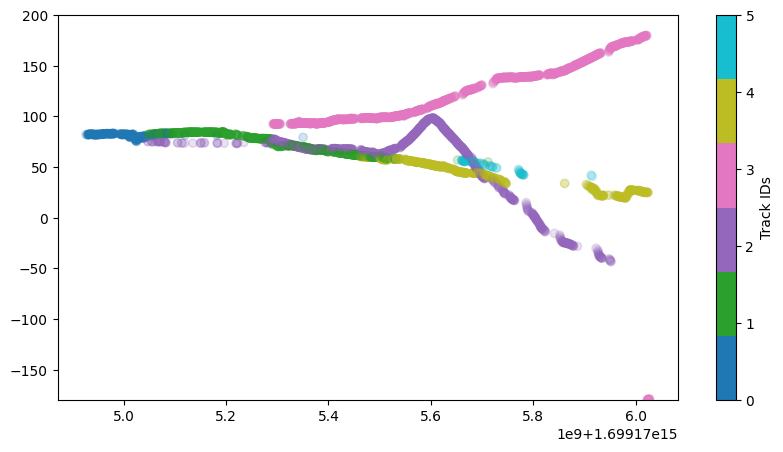

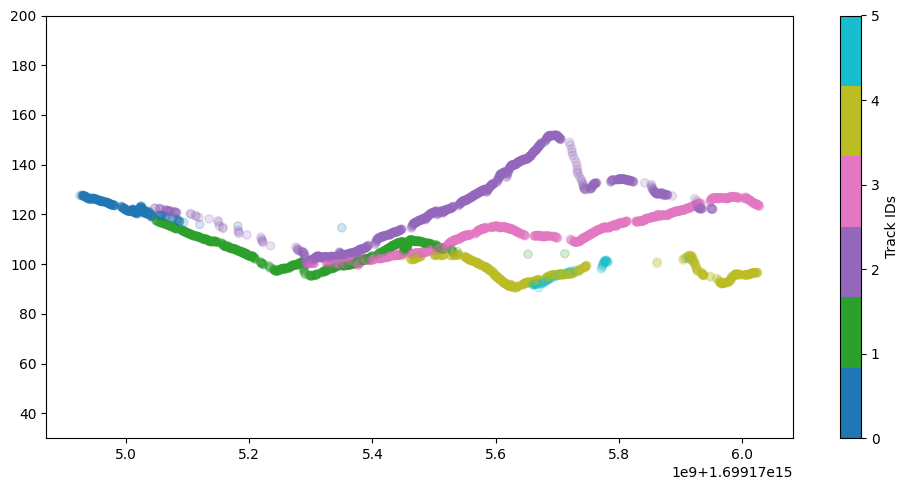

In [22]:
filename = 'tracker_output.csv'

# Read the log entries from the CSV file
kalman_log = read_log_csv(filename)
plot_log(kalman_log)
#plot_log(tracker.kalman_log)
#print(len(tracker.kalman_filters))
#print("hello")

In [8]:
time_intervals = np.linspace(df["PeakTime"].min(), df["PeakTime"].max(), num=20)
grouped_time_intervals = []

k=0
last_row = 0
for ind in range(len(time_intervals) - 1):
    # Select the data within the current interval
    observations = df[
        (df["PeakTime"] > time_intervals[ind]) &
        (df["PeakTime"] <= time_intervals[ind + 1])
    ]
    print(time_intervals[ind])
    print(time_intervals[ind+1])

1729537863445981.0
1729537924773564.8
1729537924773564.8
1729537986101148.2
1729537986101148.2
1729538047428732.0
1729538047428732.0
1729538108756315.8
1729538108756315.8
1729538170083899.5
1729538170083899.5
1729538231411483.0
1729538231411483.0
1729538292739066.8
1729538292739066.8
1729538354066650.5
1729538354066650.5
1729538415394234.2
1729538415394234.2
1729538476721817.8
1729538476721817.8
1729538538049401.5
1729538538049401.5
1729538599376985.2
1729538599376985.2
1729538660704569.0
1729538660704569.0
1729538722032152.5
1729538722032152.5
1729538783359736.2
1729538783359736.2
1729538844687320.0
1729538844687320.0
1729538906014903.8
1729538906014903.8
1729538967342487.2
1729538967342487.2
1729539028670071.0


In [16]:
df = pd.read_csv(path_doa, sep=',', names=column_names, skiprows=1)
print(df["PeakTime"].min())
print(df["PeakTime"].max())

1699174862116960
1699176027341050


In [20]:
df = pd.read_csv(path_doa, sep=',', names=column_names, skiprows=1)

# Convert 'PeakTime' column to datetime if needed; assuming the timestamp is in microseconds since epoch
df['PeakTime'] = pd.to_datetime(df['PeakTime'], unit='us')

# Determine the start time based on the minimum timestamp
start_time = df['PeakTime'].min()

# Create a new column for the interval each timestamp falls into
df['Interval'] = ((df['PeakTime'] - start_time).dt.total_seconds() // 60).astype(int)

# Count the number of data points in each 60-second interval
interval_counts = df.groupby('Interval').size()

for ind, interval in enumerate(interval_counts):
    if ind % 2 ==0:
        print(interval)


52
110
99
172
322
350
333
201
154
155


In [24]:
df = pd.read_csv(path_doa, sep=',', names=column_names, skiprows=1)

# Convert 'PeakTime' column to datetime if needed; assuming the timestamp is in microseconds since epoch
df['PeakTime'] = pd.to_datetime(df['PeakTime'], unit='us')

# Determine the start time based on the minimum timestamp
start_time = df['PeakTime'].min()

# Create a new column for the interval each timestamp falls into
vals = ((df['PeakTime'] - start_time).dt.total_seconds() // 60).astype(int)
print(vals)


0        0
1        0
2        0
3        0
4        0
        ..
3870    19
3871    19
3872    19
3873    19
3874    19
Name: PeakTime, Length: 3875, dtype: int64
